# Benchmarking simple CDR3 Beta Levenshtein distance

## Setup

In [1]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parent.resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from sklearn.metrics import PrecisionRecallDisplay
from src.datahandling.tokenisers import *
from src.modules import *
from src.utils import PCDistModelWrapper
from tcrdist.repertoire import TCRrep
import torch

### Load data

In [3]:
# df = pd.read_csv("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/vdjdb/evaluation_beta.csv")
# df = df.rename(columns={
#     'TRBV': 'v_b_gene',
#     'CDR3B': 'cdr3_b_aa',
#     'Epitope': 'epitope'
# })
# df = df[['v_b_gene', 'cdr3_b_aa', 'epitope']]
# df['count'] = 1
# df = df.drop_duplicates(subset=['v_b_gene', 'cdr3_b_aa'])

In [4]:
df = pd.read_csv("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/tcrdist/dash_human.csv").dropna()
# df = df[['v_b_gene', 'cdr3_b_aa', 'epitope', 'count']]
# df = df.drop_duplicates(subset=['v_b_gene', 'cdr3_b_aa'])

## Calculate cdists

### TCRdist

In [5]:
tr = TCRrep(cell_df = df, 
            organism = 'human', 
            chains = ['beta'])
tcrdist_pdist = squareform(tr.pw_beta)
df = tr.clone_df

In [6]:
epitope = df['epitope'].to_numpy()
within = (epitope[:, np.newaxis] == epitope[np.newaxis, :]) & (~(np.eye(len(epitope))==1))
within = squareform(within)

### BCDRBERT

In [7]:
with open('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/BCDRBERT_+ACL/config.json', 'r') as f:
    config = json.load(f)

model = BCDRClsBERT(
    **config['model']['config']
)
model.load_state_dict(torch.load('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/BCDRBERT_+ACL/state_dict.pt'))
model.eval()
model = PCDistModelWrapper(model=model, model_name='bcdrbert', tokeniser=BCDRTokeniser())

In [8]:
bvcdr3df = df.rename(columns={
    'v_b_gene': 'TRBV',
    'cdr3_b_aa': 'CDR3B'
})

In [9]:
bvcdr3bert_pdist = model.pdist(bvcdr3df.to_dict())

/home/yutanagano/Projects/tcr_embedder/.python3.8/lib64/python3.8/site-packages/torch/nn/modules/transformer.py:276: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:175.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


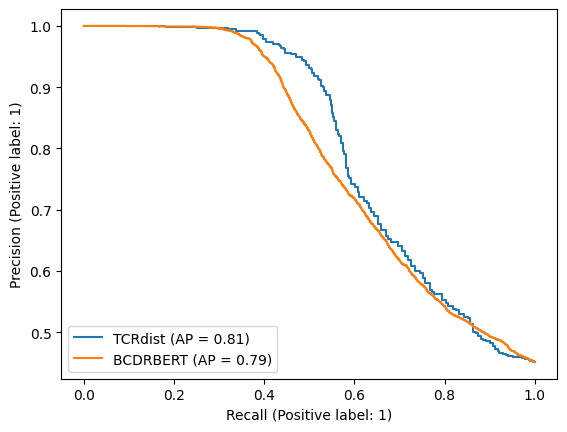

In [10]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(within, np.exp(-tcrdist_pdist/50), ax=ax, name='TCRdist')
PrecisionRecallDisplay.from_predictions(within, np.exp(-bvcdr3bert_pdist/50), ax=ax, name='BCDRBERT')